In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pubg_train = pd.read_csv('/Users/lumi/Documents/UCLA/Grad/18 FALL/273/Pubg/pudg/all/train_group.csv')

In [ ]:
pubg_train.info()
pubg_train.shape

In [3]:
pubg_train = pubg_train.drop(['groupId', 'matchId'], axis = 1)
pubg_train['teamsize'] = pubg_train.teamsize.astype('object')
pubg_train = pd.get_dummies(pubg_train)

In [4]:
ytr = pubg_train['winPlacePerc'].as_matrix()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [5]:
dfX = pubg_train.drop(['winPlacePerc', 'winPoints', 'killPoints',
                       'kills', 'assists', 'boosts', 'heals','weaponsAcquired'], axis=1)
features = dfX.columns.tolist()
Xtrain = dfX.as_matrix()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [6]:
nsamp = Xtrain.shape[0]
nf = len(features)
print('number of sample', nsamp)
print('number of feature', nf)

number of sample 592454
number of feature 22


In [62]:
from sklearn import preprocessing

Xtr = Xtrain.astype(float)
Xs = preprocessing.scale(Xtr)
#ys = preprocessing.scale(ytr)


In [63]:
#regularization with CV
from sklearn import linear_model
from sklearn import model_selection

In [64]:
from sklearn.model_selection import train_test_split

X_tr, X_ts, y_tr, y_ts = train_test_split(Xs, ytr, test_size = 0.2, train_size = 0.8)

In [66]:
# Fit linear model 
reg = linear_model.LinearRegression()
reg.fit(X_tr, y_tr)

# Measure MAE for the training set and print
yhat = reg.predict(X_tr)
mae_tr = np.mean(abs(y_tr - yhat))
print('MAE on the training data =', mae_tr)

# Measure normalized mse for the test set and print
yhat = reg.predict(X_ts)
mae_ts = np.mean(abs(y_ts-yhat))
print('MAE on the test data =', mae_ts)

MAE on the training data = 0.0729198225027529
MAE on the test data = 0.07287315541359893


Lasso Regression

In [67]:
#Fit Lasso
lassomodel = linear_model.Lasso(alpha=1e-3)
nalpha = 100
alpha_test = np.logspace(-4, 3, nalpha)
mae_ts_lasso = np.zeros(nalpha)

In [68]:
#find optimal alpha
for it, a in enumerate(alpha_test):
        lassomodel.alpha = a
        lassomodel.fit(X_tr, y_tr)
        yhat = lassomodel.predict(X_ts)
        # MAE
        mae_ts_lasso[it] = np.mean(abs(y_ts - yhat))

In [69]:
minmae = min(mae_ts_lasso)
index = np.where(mae_ts_lasso == minmae)
print('the minimum MAE =', minmae)
print('the alpha that minimizes the MAE is', alpha_test[index])

the minimum MAE = 0.07289506023497953
the alpha that minimizes the MAE is [0.0001]


In [70]:
a = alpha_test[index]
lassomodel = linear_model.Lasso(alpha = a)
lassomodel.fit(X_tr, y_tr)
yhat = lassomodel.predict(X_ts)

In [71]:
#limit target variable in 0 and 1
def confine_predictions(x):
    for i in range(len(x)):
        if x[i] > 1:
            x[i] = 1
        elif x[i] < 0:
            x[i] = 0

In [72]:
confine_predictions(yhat)

In [73]:
mae_ts = np.mean(abs(y_ts - yhat))
print(mae_ts)

0.07038500152830153


In [77]:
coef = lassomodel.coef_
rowname = list(dfX)
table = pd.DataFrame(coef, index = rowname)
print(table)

                            0
damageDealt      2.245017e-02
DBNOs           -1.648163e-02
headshotKills   -1.972281e-03
killPlace       -2.053612e-01
killStreaks     -8.580115e-02
longestKill      1.574607e-03
maxPlace         1.601889e-02
numGroups        1.556148e-02
revives          5.548212e-04
rideDistance     2.393491e-02
roadKills        2.971793e-05
swimDistance     2.262831e-03
teamKills       -7.775316e-04
vehicleDestroys  6.768504e-07
walkDistance     1.231136e-01
matchDuration   -3.111114e-02
KADistance       0.000000e+00
KADuration      -1.886688e-02
itemDuration     4.521339e-02
itemDistance    -2.860235e-04
teamsize_1      -4.286486e-02
teamsize_2       4.869134e-17


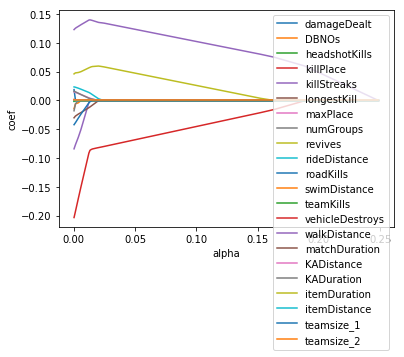

In [78]:
alphas1, coeffs, _ = linear_model.lasso_path(X_tr, y_tr, method='lasso', alpha = alpha_test)
coeffs.shape #predictor * alpha
#match an alpha with a row of coef


for coef_l in coeffs:
    plt.plot(alphas1, coef_l)
    
plt.xlabel('alpha')
plt.ylabel('coef')
plt.legend(rowname, loc='upper right')

In [79]:
nonzero = (coeffs != 0).astype(int)
nnz = np.sum(nonzero, axis=1)

nonzerotable = pd.DataFrame(nnz, index= rowname)
nonzerotable.columns = ['nnz']
nonzerotable.sort_values(by=['nnz'], ascending=False)

,nnz
walkDistance,99
killPlace,96
itemDuration,93
rideDistance,66
matchDuration,64
maxPlace,63
numGroups,63
teamsize_2,59
teamsize_1,59
killStreaks,57


Ridge Regression

In [80]:
ridgemodel = linear_model.Ridge(alpha=1e-3)
nalpha = 100
alpha_test = np.logspace(-4, 3, nalpha)
mae_ts_ridge = np.zeros(nalpha)

In [82]:
#find optimal alpha
for it, a in enumerate(alpha_test):
        ridgemodel.alpha = a
        ridgemodel.fit(X_tr, y_tr)
        yhat = ridgemodel.predict(X_ts)
        # MAE
        mae_ts_ridge[it] = np.mean(abs(y_ts - yhat))

In [84]:
minmae = min(mae_ts_ridge)
index = np.where(mae_ts_ridge == minmae)
print('the minimum MAE =', minmae)
print('the alpha that minimizes the MAE is', alpha_test[index])

the minimum MAE = 0.07287336803148992
the alpha that minimizes the MAE is [0.0001]


In [85]:
a = alpha_test[index]
ridgemodel = linear_model.Ridge(alpha = a)
ridgemodel.fit(X_tr, y_tr)
yhat = ridgemodel.predict(X_ts)

In [86]:
confine_predictions(yhat)

In [87]:
mae_ts = np.mean(abs(y_ts - yhat))
print(mae_ts)

0.07034526554806463


In [88]:
coef = ridgemodel.coef_
rowname = list(dfX)
table = pd.DataFrame(coef, index = rowname)
print(table)

                        0
damageDealt      0.024055
DBNOs           -0.017203
headshotKills   -0.002139
killPlace       -0.206145
killStreaks     -0.086411
longestKill      0.001777
maxPlace         0.016094
numGroups        0.015648
revives          0.000691
rideDistance     0.023965
roadKills        0.000130
swimDistance     0.002348
teamKills       -0.000855
vehicleDestroys  0.000086
walkDistance     0.122875
matchDuration   -0.031387
KADistance       0.001482
KADuration      -0.019930
itemDuration     0.045128
itemDistance    -0.001755
teamsize_1      -0.021565
teamsize_2       0.021565


In [90]:
nonzero = (coeffs != 0).astype(int)
nnz = np.sum(nonzero, axis=1)

nonzerotable = pd.DataFrame(nnz, index= rowname)
nonzerotable.columns = ['nnz']
nonzerotable.sort_values(by=['nnz'], ascending=False)

,nnz
walkDistance,99
killPlace,96
itemDuration,93
rideDistance,66
matchDuration,64
maxPlace,63
numGroups,63
teamsize_2,59
teamsize_1,59
killStreaks,57
